In [1]:
import numpy as np
import torch
import nflows

import matplotlib
import matplotlib.pyplot as plt
# %matplotlib widget

# import corner

import seaborn as sns
sns.set()

In [2]:
import sys
sys.path.append('/Users/ratzenboe/Documents/programs/pythonProject/density-deconvolution-astro/')

In [3]:
device = torch.device("cpu")

# Create data

In [4]:
means = torch.Tensor([
    [0.0, 0.0],
    [2, 3],
    [2, -3]
])
covars = torch.Tensor([
    [
        [0.1, 0],
        [0, 1.5]
    ],
    [
        [1, 0],
        [0, 0.1]
    ],
    [
        [1, 0],
        [0, 0.1]
    ]
])

Z = torch.distributions.MultivariateNormal(loc=means, covariance_matrix=covars).sample((100_000,)).reshape((-1, 2))

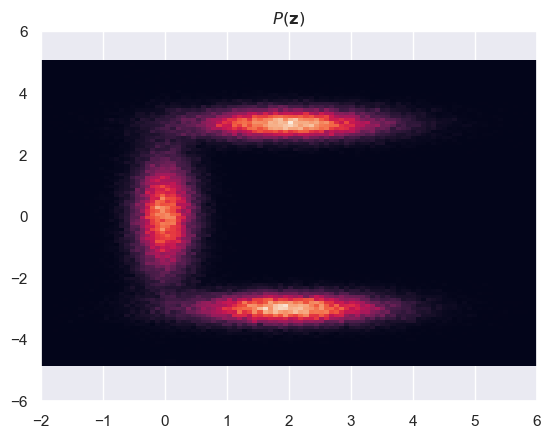

In [5]:
idx = torch.randperm(Z.shape[0])
Z = Z[idx]
Z_train = Z[:Z.shape[0] // 2]
Z_test = Z[Z.shape[0] // 2:]

x_lim = (-2, 6)
y_lim = (-6, 6)

fig, ax = plt.subplots()
plt.hist2d(Z_train[:, 0].numpy(), Z_train[:, 1].numpy(), bins=100) #, ax=ax)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.set_title(r'$P(\mathbf{z})$');

# Add error

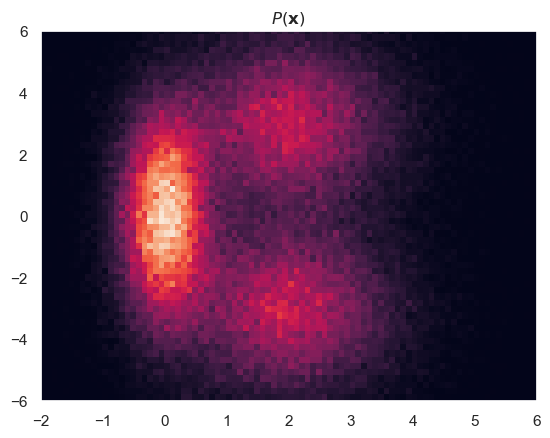

In [6]:
S = torch.Tensor([
    [0.1, 0],
    [0, 3]
])
X = Z + torch.distributions.MultivariateNormal(loc=torch.Tensor([0.0, 0.0]), covariance_matrix=S).sample((Z.shape[0],))
X_train = X[:X.shape[0] // 2]
X_test = X[X.shape[0] // 2:]

fig, ax = plt.subplots()
plt.hist2d(X_train[:, 0].numpy(), X_train[:, 1].numpy(), bins=100) #, ax=ax
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.set_title(r'$P(\mathbf{x})$');

# Train 

In [7]:
from deconv.gmm.data import DeconvDataset

train_data = DeconvDataset(X_train, torch.linalg.cholesky(S.repeat(X_train.shape[0], 1, 1)))
test_data = DeconvDataset(X_test, torch.linalg.cholesky(S.repeat(X_test.shape[0], 1, 1)))

In [11]:
# from deconv.gmm.sgd_deconv_gmm import SGDDeconvGMM

# gmm = SGDDeconvGMM(
#     3,
#     2,
#     batch_size=200,
#     lr=1e-1,
#     epochs=100,
#     #device=torch.device('cpu')
# )
# gmm.fit(train_data, verbose=True)

In [8]:
# S.shape

In [9]:
from deconv.flow.svi import SVIFlow

svi = SVIFlow(
    2,
    5,
    device=torch.device("cpu"),
    batch_size=512,
    epochs=20,
    lr=1e-4,
    n_samples=50,
    use_iwae=True
)

In [10]:
%%time
svi.fit(train_data, val_data=None)

/Users/ratzenboe/anaconda3/envs/torch/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


Epoch 0, Train Loss: -5.022479596354167
Epoch 1, Train Loss: -4.091193167317709
Epoch 2, Train Loss: -4.08227394938151
Epoch 3, Train Loss: -4.08074187906901
Epoch 4, Train Loss: -4.0790619840494795
Epoch 5, Train Loss: -4.080229866536459
Epoch 6, Train Loss: -4.078827728678386
Epoch 7, Train Loss: -4.078160793457031
Epoch 8, Train Loss: -4.077211645507813
Epoch 9, Train Loss: -4.077676323242187
Epoch 10, Train Loss: -4.077692073567708
Epoch 11, Train Loss: -4.0779201961263025
Epoch 12, Train Loss: -4.076398741861979
Epoch 13, Train Loss: -4.076400731608073
Epoch 14, Train Loss: -4.075618629557292
Epoch 15, Train Loss: -4.075636095377604
Epoch 16, Train Loss: -4.075234261067708
Epoch 17, Train Loss: -4.074759658203125
Epoch 18, Train Loss: -4.075849958496094
Epoch 19, Train Loss: -4.074948233235677
CPU times: user 1h 28min 6s, sys: 1h 12min 31s, total: 2h 40min 38s
Wall time: 1h 13min 23s


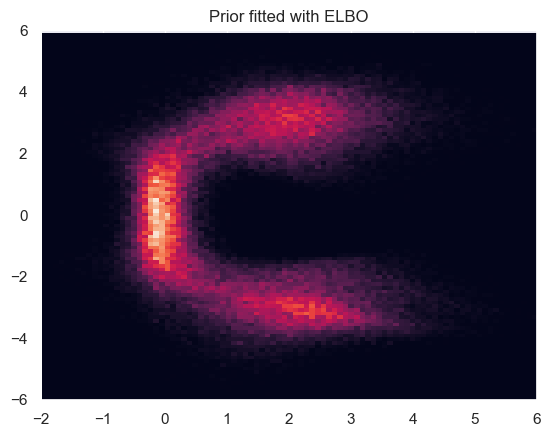

In [15]:
torch.set_default_tensor_type('torch.FloatTensor')
prior_samples = svi.sample_prior(100_000)

fig, ax = plt.subplots()
plt.hist2d(prior_samples[0, :, 0].numpy(), prior_samples[0, :, 1].numpy(), bins=100) #, ax=ax)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.set_title('Prior fitted with ELBO');

In [12]:
mean = np.array([[3.0, 0.0], [0.0, 0.0]])
cov = np.array([
    [
        [0.1, 0],
        [0, 3]
    ],
    [
        [0.1, 0],
        [0, 3]
    ]
])
test_point = [
    torch.Tensor(mean).to(svi.device),
    torch.cholesky(torch.Tensor(cov)).to(svi.device)
]
torch.set_default_tensor_type('torch.FloatTensor')
posterior_samples = svi.resample_posterior(test_point, 10000)

from deconv.gmm.plotting import plot_covariance
fig, ax = plt.subplots()
plt.hist2d(posterior_samples[0, :, 0].numpy(), posterior_samples[0, :, 1].numpy(), ax=ax)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
plot_covariance(
    mean[0],
    cov[0],
    ax=ax,
    color='r'
)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.set_title('Recognition network samples for test point, fitted using ELBO.');

/var/folders/q4/vrqcgjz9259cd9jkzmpv3zth0000gn/T/ipykernel_40833/386404632.py:14: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1703.)
  torch.cholesky(torch.Tensor(cov)).to(svi.device)


TypeError: object of type 'generator' has no len()

In [19]:
rsamples = svi.resample_posterior(test_point, 10_000)

fig, ax = plt.subplots()
corner.hist2d(rsamples[0, :, 0].cpu().numpy(), rsamples[0, :, 1].cpu().numpy(), ax=ax)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
plot_covariance(
    mean[0],
    cov[0],
    ax=ax,
    color='r'
)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.set_title('Resampled posterior for test point, fitted using ELBO.')

TypeError: object of type 'generator' has no len()